# geoOptimiser

Once you have created your geometry via geoAssembler, there's a good chance that the centre of the geometry is not the centre of the beam. This can very negatively effect the results of azimuthal integration, or any other form of analysis which requires precise knowledeg of the centre of the beam.

geoOptimiser was created to solve this problem. It can be imported from geoAssembler as:

In [1]:
import geoAssembler.optimiser as geoOptimiser

From here import all of the packages you would normally use:

In [2]:
from extra_data import RunDirectory, stack_detector_data
from extra_geom import AGIPD_1MGeometry

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import os.path

Optionally if you want to use multiprocessing to speed up the optimisation process you can also import `Pool` out of the multiprocessing module:

In [5]:
from multiprocessing import Pool

Now create a geomtery and run object:

In [6]:
geom = AGIPD_1MGeometry.from_quad_positions(quad_pos=[
        (-525, 625),
        (-550, -10),
        (520, -160),
        (542.5, 475),
    ])

In [7]:
run_path = '/gpfs/exfel/exp/SPB/201831/p900039/proc/r0273/'
run_available = os.path.isdir(run_path)
if run_available:
    run = RunDirectory('/gpfs/exfel/exp/SPB/201831/p900039/proc/r0273/')
else:
    print("Run not available, falling back to using saved frame")

geoOptimiser provides a convenient averaging function for AGIPD which applies some additional masking (e.g. to the edges of the ASICS and to known bad regions of the detector), this does not need to be used though, any 2d array can be used with the optimiser

In [8]:
if run_available:
    frame = geoOptimiser.avg_frame(run, geom, 60, pulse_pattern=slice(10, -10))[0]
else:
    print("Run not available, falling back to using saved frame")
    saved_frame_path = os.path.join(
        os.path.dirname(geoOptimiser.__file__), "..", "tests", "optimiser-test-frame.npy")
    sf = np.load(saved_frame_path)

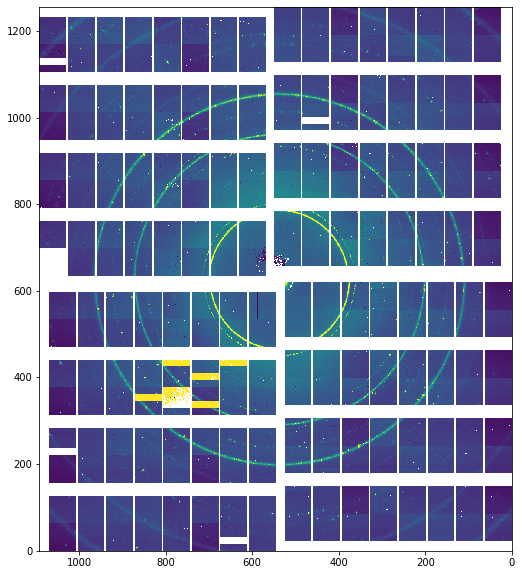

In [9]:
plt.figure(figsize=(12, 10))
plt.imshow(frame, origin='lower', interpolation='none')
plt.gca().invert_xaxis()

Creating the optimiser requires the geometry object, the frame, and the distance to the samlpe in mm:

In [10]:
optimiser = geoOptimiser.CentreOptimiser(geom, frame, sample_dist_mm=200)

The optimiser can then perform '2d integration', which just unrolls the frame around the centre:

In [11]:
missaligned_2dint = optimiser.integrate2d(frame).intensity
missaligned_2dint_r = optimiser.integrate2d(frame).radial
missaligned_2dint_a = optimiser.integrate2d(frame).azimuthal

#  Ignoring the first/last 100 radial pixels as these regions are very
#  distorted, and the integration results there are not reliable
missaligned_1dint = np.nanmean(missaligned_2dint, axis=0)[100:-100]
missaligned_1dint_x = optimiser.integrate2d(frame).radial[100:-100]

In [12]:
brightest_ring_idx = np.where(missaligned_1dint == np.nanmax(missaligned_1dint))[0][0] + 100

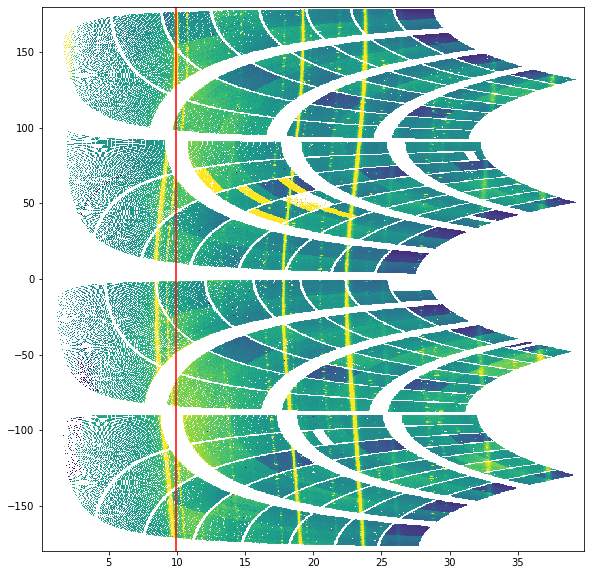

In [13]:
plt.figure(figsize=(12, 10))
plt.imshow(np.clip(missaligned_2dint, 0, 600),
    extent=(
        min(missaligned_2dint_r), max(missaligned_2dint_r),
        min(missaligned_2dint_a), max(missaligned_2dint_a)
    ),
   aspect=(max(missaligned_2dint_r)/max(missaligned_2dint_a)/2),
   interpolation='nearest'
)
plt.axvline(missaligned_2dint_r[brightest_ring_idx], color='r')

Above you can see that the circular diffraction rings are now lines, however these lines are slightly curved/wavy. This wavyness indicates that the centre of the geometry is not the same as the centre of the diffraction rings.

Performing azimuthal integration when the centre is not correct will smear out the rings over a wide area, reducing the overall signal and very negatively affecting the results you receive:

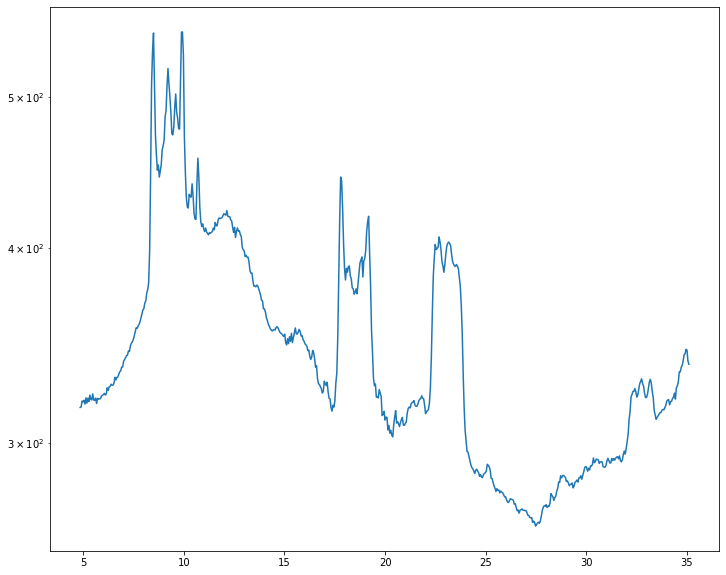

In [14]:
plt.figure(figsize=(12, 10))
plt.plot(missaligned_1dint_x, missaligned_1dint)
plt.yscale('log')

To correct for this, call the `optimise` method of the optimiser object. Optionally - **if you are running this on  a dedicated node** - a pool can be used to greatly speed up the optimisation process:

In [15]:
%%time
with Pool(32) as pool:
    res = optimiser.optimise(pool=pool)

Trying 121 combinations, radius 50, stepsize 10 - found centre at -> [-10   0]
Trying 121 combinations, radius 10, stepsize 2 - found centre at -> [-12  -4]
Trying 169 combinations, radius 3, stepsize 0.5 - found centre at -> [-13.   -4.5]
Optimal quad positions:  [
    (-512.0, 629.5),
    (-537.0, -5.5),
    (533.0, -155.5),
    (555.5, 479.5),
]
CPU times: user 16 s, sys: 40.6 s, total: 56.6 s
Wall time: 1min 18s


The output of the optimisationis an object which contains the corrected quadrant corner positions, optimal centre offset (in this case `[-13.0, -4.5]`), as well as all of the individual intermediary results which typically do not have to be looked at.

You can now use the optimal quad positions to create a corrected geometry:

In [16]:
corrected_geom = geom = AGIPD_1MGeometry.from_quad_positions(quad_pos=[
    (-512.0, 629.5),
    (-537.0, -5.5),
    (533.0, -155.5),
    (555.5, 479.5),
])

In [17]:
corrected_optimiser = geoOptimiser.CentreOptimiser(corrected_geom, frame, sample_dist_mm=200)

In [18]:
corrected_2dint = corrected_optimiser.integrate2d(frame).intensity
corrected_2dint_r = corrected_optimiser.integrate2d(frame).radial
corrected_2dint_a = corrected_optimiser.integrate2d(frame).azimuthal

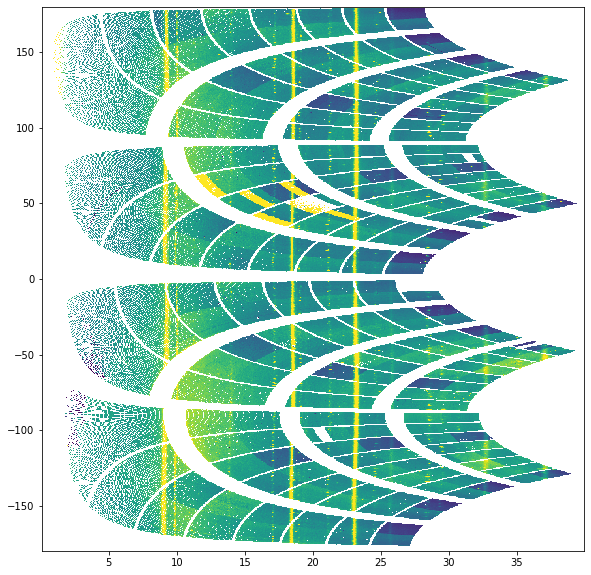

In [19]:
plt.figure(figsize=(12, 10))
plt.imshow(np.clip(corrected_2dint, 0, 600),
    extent=(
        min(corrected_2dint_r), max(corrected_2dint_r),
        min(corrected_2dint_a), max(corrected_2dint_a)
    ),
   aspect=(max(corrected_2dint_r)/max(corrected_2dint_a)/2),
   interpolation='nearest'
)

As you can see, the wavy lines are now much straighter. Performing azimuthal integration on this will now show:

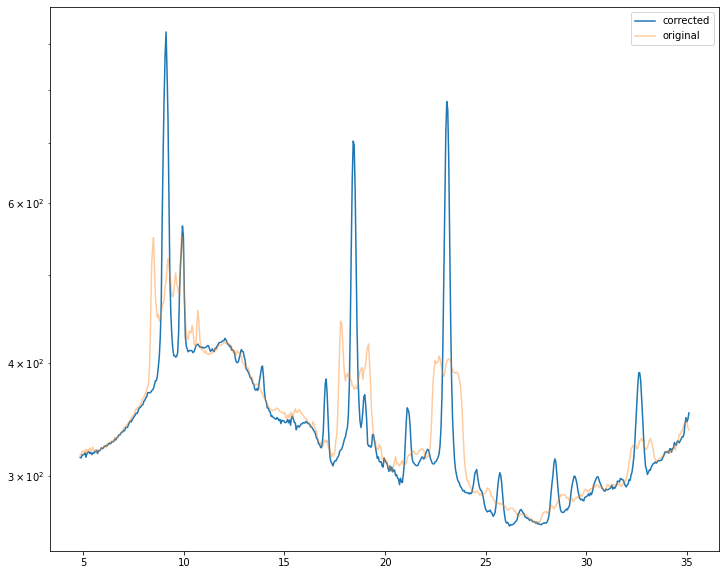

In [20]:
plt.figure(figsize=(12, 10))
plt.plot(missaligned_1dint_x, (np.nanmean(corrected_2dint, axis=0)[100:-100]), label="corrected")
plt.plot(missaligned_1dint_x, (missaligned_1dint), label="original", alpha=0.4)
plt.yscale('log')
plt.legend()

Which is a massive improvement over the previous result.

If the optimisation has not helped, first check that you can clearly see rings in the image, secondly check the resulting minimisation arrays:

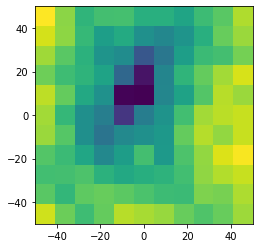

In [21]:
stage_result = res.results[0]
plt.imshow(
    stage_result.array,
    extent=(
        min(stage_result.xs), max(stage_result.xs),
        min(stage_result.ys), max(stage_result.ys)
    )
)

Here we can see the first coarse search array, which ranges from -50 to +50 pixels around the centre of the image. The dark blob in the middle is region of minimum value.

If this blob is right against the edge of the plot, this means that the centre very far off. In this situation you can run the optimiser once, get the optimal centre coordinates, then re-run the optimiser and set `centre_offset` to the previous optimum coordinates. This should then improve the results.

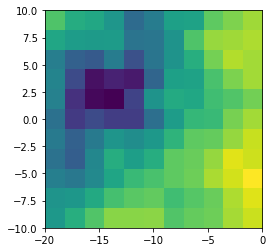

In [22]:
stage_result = res.results[1]
plt.imshow(
    stage_result.array,
    extent=(
        min(stage_result.xs), max(stage_result.xs),
        min(stage_result.ys), max(stage_result.ys)
    )
)

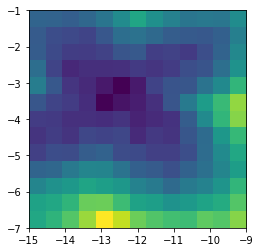

In [23]:
stage_result = res.results[2]
plt.imshow(
    stage_result.array,
    extent=(
        min(stage_result.xs), max(stage_result.xs),
        min(stage_result.ys), max(stage_result.ys)
    )
)

Above we see that there is a very dark area, which is progressively zoomed into, and at no point is the dark area going off the edge of the plot. This is a good sign that we have found the optimum centre.

If you're curious, it's possible to (relatively) quickly calculate the values over a large pixel grid:

In [24]:
%%time
with Pool(80) as pool:
    large_search = optimiser._find_centre(radius=200, stepsize=5, pool=pool)

CPU times: user 25.9 s, sys: 57.9 s, total: 1min 23s
Wall time: 1min 55s


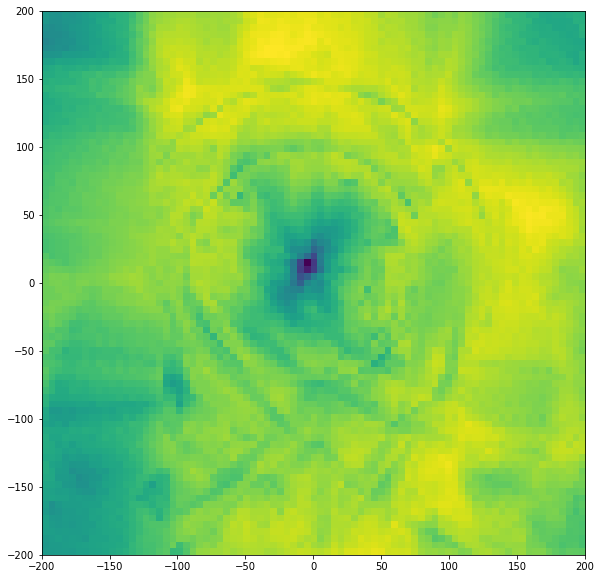

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(
    np.log(large_search.array),
    extent=(
        min(large_search.xs), max(large_search.xs),
        min(large_search.ys), max(large_search.ys)
    )
)